# Neural Networks for Data Science Applications
## Second Homework: Experimenting with continual learning

**Name**: *Daniel Mauricio Jimenez Gutierrez*

**Matricola**: *1939216*

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (19/01/2022), the final deadline is **17/01/2022 at 23:59**.

**Overview**: The homework is composed of four parts: (i) selecting a dataset; (ii) implementing a custom component (ONLY if you did not submit the first homework or if you want to improve your mark); (iii) implementing a neural network and training it on the dataset; (iv) implementing an additional continual learning strategy on top of it.

> 🟨 **Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

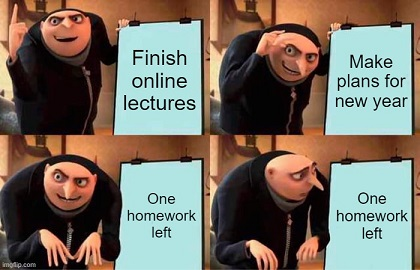

In [ ]:
import numpy as np
import pandas as pd
import time
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout,MaxPooling2D,Conv2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split


# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Try not to use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

**DESCRIPTION OF THE CODE**: *Provide a small description of the dataset here (e.g., source, task, bibliographic reference if necessary...).*

The data set defined to solve my HW is  "Scene Classification". The latter contains around 25k images from a wide run of common scenes from all around the world. The TASK is to distinguish which kind of scene can the picture be categorized into. It has a label of 6 classes:
0 = Buildings

1 = Forests

2 = Mountains

3 = Glacier

4 = Street

5 = Sea

This dataset was retrieved from Kaggle and it can be downloaded from the next [link](https://www.kaggle.com/nitishabharathi/scene-classification).


Then, the first step to follow is to download the dataset to work with it here in Google Colab. The following lines of code do that process almost automatically. The only non-automatic part is when uploading the API token. So, when it comes, the user has to upload the JSON file attached to the submission (just for simplicity for the reader).

In [ ]:
# Install kaggle
!pip -q install kaggle

# Upload manually the JSON file downloaded from kaggle (API token). They file is attached to the submission
from google.colab import files
files.upload()

# Create Kaggle folder
!mkdir ~/.kaggle

# Copy JSON file into the created foder
!cp kaggle.json ~/.kaggle/

# Provide permissions to the JSON file to work
!chmod 600 ~/.kaggle/kaggle.json

# List all the datasets available in Kaggle
# !kaggle datasets list

# Download the dataset in zip format
!kaggle datasets download -d nitishabharathi/scene-classification

#Decompress the data
!unzip -o -q scene-classification.zip

Saving kaggle.json to kaggle.json
 99% 356M/361M [00:03<00:00, 78.3MB/s]
100% 361M/361M [00:03<00:00, 95.8MB/s]


The next step is to load the data and count along the classes to check how imbalanced the label is. It is relevant to state that I took a 50% random sample of the data to avoid long-running times in the models generated below.


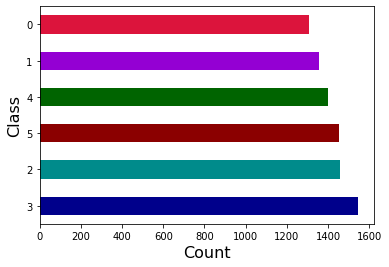


Number of images in the the whole database (train set): 8517


In [ ]:
# Read CSV with train information of the images
df = pd.read_csv("train-scene classification/train.csv", dtype={'label': str})

# Take a random sample of the data to reduce training time in the models
df = df.sample(frac = 0.50, random_state = 0)

# Create bars with different colors
df['label'].value_counts().plot(kind='barh', color=['darkblue', 'darkcyan', 'darkred', 'darkgreen', 'darkviolet', 'crimson'])
 
# Provide names on x-axis and y-axis
plt.xlabel('Count', fontsize=16)
plt.ylabel('Class', fontsize=16)

# Show graph
plt.show()

print("\nNumber of images in the the whole database (train set):", df.shape[0])

As depicted in the previous chart, the number of images per class is between 1300 and 1500. That indicates that the data set is not unbalanced, and I can proceed to define the working environment for the model.

In the following code, I changed the size of the images to 150 x 150. The latter is because a CNN needs the figure to have the same size. I picked 150 because the current sizes vary around 100 and 400, and taking 150 seems a good average. Besides, other authors in Kaggle also use that approach. Later, I split the data into the train (70%) and test (30%). Finally, I applied a normalization for the pixels by dividing each channel by 255 since I'm working with RBG images, and it will help the training process and the final accuracy.

In [ ]:
# Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

# Create lists to store the data and labels
data = []
labels = []

# Define the path of the data
data_directory = "train-scene classification/train/"

# Define whole train set of images and labels
for i in tqdm(df.index):
  # Load each image 
  img = mpimg.imread(data_directory + df['image_name'][i])
  # Resize the image
  img = cv2.resize(img,(150,150))
  # Add image to list
  data.append(img)
  # Add label to list
  labels.append(df['label'][i])

# Convert train dataset in ndarray
data = np.array(data)
labels = np.array(labels)

# Create train and test sets (70/30)
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.70, random_state = 0)

# # Modify the type of y into np.uint8
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

print("Shape of images in train:",x_train.shape)
print("Shape of labels in train:",y_train.shape)
print("Shape of images in test:",x_test.shape)
print("Shape of labels in test:",y_test.shape)

# Get number of images in train
n_train = x_train.shape[0]

# Get number of images in test
n_test = x_test.shape[0]

# Set batch size
batch_size = 32

# Normalizing pixels of images by 255 (since its a RGB)
data_generator = ImageDataGenerator(rescale=1./255)

# Create the generator fro train and test
train_generator = data_generator.flow(x_train, y_train, batch_size = batch_size)
test_generator = data_generator.flow(x_test, y_test, batch_size = batch_size)

del data, labels
gc.collect()

100%|██████████| 8517/8517 [00:12<00:00, 675.07it/s]


Shape of images in train: (5961, 150, 150, 3)
Shape of labels in train: (5961,)
Shape of images in test: (2556, 150, 150, 3)
Shape of labels in test: (2556,)


2877

As shown, for training I ended up with 5,961 images and for test with 2,556. 

### Exercise 1: Implementing a custom object (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 3/5). For a mark of 4/5, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 2 and 3, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*. 

The **S-Shaped ReLU** (SReLU) [1] is defined as:

$$
\phi(s) = \begin{cases} t^r + a^r(s - t^r) & \text{ if } s > t^r \\ s & \text{ if } t^r > s > t^l \\ t^l + a^l(s - t^l) & \text{ if } s < t^l \end{cases} \,.
$$

The four parameters $t^r, a^r, t^l, a^l$ are trained via back-propagation, and they are **different for each unit in the layer**. For this exercise, you need to define a `tf.keras.Layer` implementing the SReLU logic. Then, plot an example of the resulting activation function, and its derivative (computed using the GradientTape). 

> 🧐 Keep in mind that you are replicating Exercises 1 and 2 from the [first homework](https://colab.research.google.com/drive/1dVvvsSRGxzIUE1-Ntg6PEGT-CW4RXMOH?usp=sharing), so any consideration from there apply also here.

[1] https://arxiv.org/pdf/1512.07030v1.pdf

In [ ]:
# Insert your component here
class SReLU(tf.keras.Layer):
  # ...

In [ ]:
# Show a plot of the SReLU and its derivative

### Exercise 2: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. If you did Exercise 1, **include your custom component here**. Otherwise, you are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

**DESCRIPTION OF THE CODE**: *Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

The model proposed for the classification task defined above has the upcoming considerations:

- It starts with a **Convolutional 2D filter** using 64 as the number of filters to learn. It also sets a kernel size of 3 and a zero-padding (same) for the convolution. Moreover, it includes an input shape for the figures of 15,150, as explained previously. Finally, it applies a RELU activation function.

- The next layer is a **Max-pooling 2D**. As default, it includes a pool size (window size) of 2, and padding equals valid, which means no padding is applied.

- The following layer used is **flatten** the input of the previous layer. It is employed to make the latter multidimensional output linear to pass it onto a posterior "Dense" layer.

- Later I applied **Dropout** with a probability of 0.6 to tackle the possible overfitting present in training.

- And finally, I use a **fully-connected** layer to connect the previous output with the final output of the CNN, using 6 neurons that are referred to the number of classes of the label. It also includes a softmax activation function since this is a classification exercise.

Also, I provided an Adam optimizer with a learning rate of 0.001 as the one used frequently for this task. For the definition of the model, I created the CNN class as follows:

In [ ]:
class CNN():
  """
  Class used to define the desired model and compile it
  """
  def __init__(self, input_shape=(150, 150, 3), num_classes = 6):
    """
    :param input_shape: Shape of the images
    """
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.model = self.CNN_definition()
      
  def CNN_definition(self):
    """
    Define define the desired model
    """
    # Define the model
    model = Sequential()
    model.add(Conv2D(64, 3, activation="relu", padding="same", input_shape=self.input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(self.num_classes,activation="softmax"))
    
    return model

  def retrieve_compiled_model(self, function_loss):
    """
    Compile the proposed model
    :param function_loss: Loss function desired
    """
    # Retrieve model
    compiled_model = self.model

    # Compile the model
    compiled_model.compile(loss = function_loss, optimizer = Adam(learning_rate=0.001), metrics = SparseCategoricalAccuracy())
    return compiled_model

# Define the function loss to use
function_loss = SparseCategoricalCrossentropy()

# Define and compile the model
model = CNN()
model = model.retrieve_compiled_model(function_loss)

# Get the sumary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 360000)            0         
                                                                 
 dropout (Dropout)           (None, 360000)            0         
                                                                 
 dense (Dense)               (None, 6)                 2160006   
                                                                 
Total params: 2,161,798
Trainable params: 2,161,798
Non-trainable params: 0
______________________________________________

As shown in the table above, 2,161,798 parameters will be trained inside the CNN. 

To train the model, I defined the step sizes equal to 50 since it provided a reasonable threshold between the training time and the accuracy obtained. 

In [ ]:
# You can train using fit() or a custom training loop, equivalently.

start = time.time()

# Define step sizes
step_size_train = 50
step_size_val = 50

# Set number of epochs
n_epochs = 10

# Train the model
history = model.fit(train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = n_epochs,
                   validation_data = test_generator,
                   validation_steps = step_size_val,
                   callbacks=[GarbageCollectorCallback()]) 
end = time.time()
print("Elapsed training time:", end - start)

Epoch 1/10
50/50 [==============================] - 93s 2s/step - loss: 3.3018 - sparse_categorical_accuracy: 0.3994 - val_loss: 1.1969 - val_sparse_categorical_accuracy: 0.5375
Epoch 2/10
50/50 [==============================] - 66s 1s/step - loss: 1.0257 - sparse_categorical_accuracy: 0.6263 - val_loss: 1.0649 - val_sparse_categorical_accuracy: 0.6319
Epoch 3/10
50/50 [==============================] - 77s 2s/step - loss: 0.8521 - sparse_categorical_accuracy: 0.6956 - val_loss: 0.9878 - val_sparse_categorical_accuracy: 0.6488
Epoch 4/10
50/50 [==============================] - 74s 1s/step - loss: 0.7818 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.6550
Epoch 5/10
50/50 [==============================] - 50s 1s/step - loss: 0.6572 - sparse_categorical_accuracy: 0.7700 - val_loss: 0.9075 - val_sparse_categorical_accuracy: 0.6656
Epoch 6/10
50/50 [==============================] - 47s 936ms/step - loss: 0.6113 - sparse_categorical_accurac

As depicted, the learning process took around 11 minutes to finish.

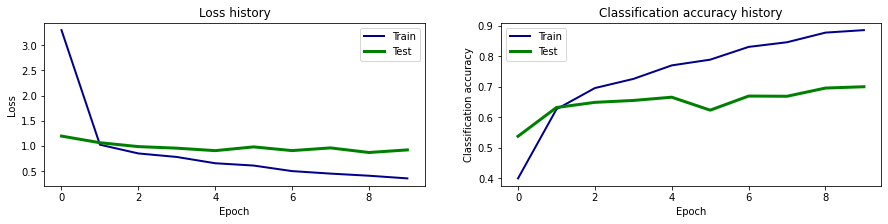

In [ ]:
# Retrieve the training loss
train_loss = history.history['loss']

# Retrieve the test loss
test_loss = history.history['val_loss'] 

# Retrieve the training accuracy
train_acc = history.history['sparse_categorical_accuracy']

# Retrieve the test accuracy
test_acc = history.history['val_sparse_categorical_accuracy'] 

# Plot the history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
ax1.plot(train_loss, label='Train', color="darkblue", linewidth=2)
ax1.plot(test_loss, label='Test', color="green", linewidth=3)
ax1.set_title('Loss history')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.legend()
ax2.plot(train_acc, label='Train', color="darkblue", linewidth=2)
ax2.plot(test_acc, label='Test', color="green", linewidth=3)
ax2.set_title('Classification accuracy history')
ax2.set(xlabel='Epoch', ylabel='Classification accuracy')
ax2.legend()

Finally, after the training process, the accuracy obtained for the model in the test is close to 70%. Besides, looking at the charts, taking around 5 epochs to train the model can be a good number for early stopping it. Moreover, the Dropout applied didn't work well since after epoch 4, there is a big difference between the train and test lines.

### Exercise 3 (6 points): Continual learning

In the third part of the homework, you are asked to implement a continual learning setup with the following characteristics: 

* **Task-incremental learning**: split the dataset in > 2 task (e.g., dividing the outputs into disjoint subsets). The model will be a multi-head model, similar to what we saw in the slides.
* Train the model on the tasks sequentially, using **elastic weight consolidation** (EWC).
* Show at least the mean accuracy (as defined in the slides) and the backward transfer after training. You can also show some *performance graphs* similar to the ones from the slides (with the id of the task on the x-axis).

🟩 **Please do:**

1. Carefully read [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate) from the TensorFlow website. You can implement EWC in several ways.
2. It would be preferable to implement the accuracy and the backward transfer by subclassing `tf.keras.metrics.Metric`.
3. Comment the code and provide a complete description below.

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

Inside the next cell, I included a Python class to calculate both the Global Accuracy and the Backward Transfer.

In [ ]:
# Define metrics here:
class BackwardTransfer():
  """
  Class used to calculate the metrics for the EWC performance
  """

  def __init__(self, list_accuracies, n_tasks = 3):
    """
    :param list_accuracies: Values of the accuracies to take into account
    :param n_tasks: Total number of tasks
    """
    self.list_accuracies = list_accuracies
    self.n_tasks = n_tasks
  
  def calculate_global_accuracy(self):
    """
    Calculate the Global accuracy following the slides' formula
    """
    global_accuracy = (sum(self.list_accuracies) / (0.5 * self.n_tasks * (self.n_tasks + 1)))
    return global_accuracy


  def calculate_BackwardTransfer(self):
    """
    Calculate the Backward Transfer metric following the slides' formula
    """
    backward_transfer = (sum(self.list_accuracies) / (0.5 * self.n_tasks * (self.n_tasks - 1)))
    return backward_transfer

Now I defined the partition of the dataset in three tasks as follows:

- *Task A:* Contains the images for 0 = Buildings and 1 = Forests
- *Task B:* Contains the images for 2 = Mountains and 3 = Glacier
- *Task C:* Contains the images for 4 = Street and 5 = Sea

In [ ]:
# Split the dataset

# Define number of tasks
n_tasks = 3

# Get Ids for each task in train
idx_train_taskA = np.isin(y_train, [0,1])
idx_train_taskB = np.isin(y_train, [2,3])
idx_train_taskC = np.isin(y_train, [4,5])

# Get Ids for each task in test
idx_test_taskA = np.isin(y_test, [0,1])
idx_test_taskB = np.isin(y_test, [2,3])
idx_test_taskC = np.isin(y_test, [4,5])

# Define working datasets for train 
x_train_taskA = x_train[idx_train_taskA]
x_train_taskB = x_train[idx_train_taskB]
x_train_taskC = x_train[idx_train_taskC]
y_train_taskA = y_train[idx_train_taskA] % 2
y_train_taskB = y_train[idx_train_taskB] % 2
y_train_taskC = y_train[idx_train_taskC] % 2

# Define working datasets for test
x_test_taskA = x_test[idx_test_taskA]
x_test_taskB = x_test[idx_test_taskB]
x_test_taskC = x_test[idx_test_taskC]
y_test_taskA = y_test[idx_test_taskA] % 2
y_test_taskB = y_test[idx_test_taskB] % 2
y_test_taskC = y_test[idx_test_taskC] % 2

print("Shape of images in train for task A:",x_train_taskA.shape)
print("Shape of labels in train for task A:",y_train_taskA.shape)
print("Shape of images in train for task B:",x_train_taskB.shape)
print("Shape of labels in train for task B:",y_train_taskB.shape)
print("Shape of images in train for task C:",x_train_taskC.shape)
print("Shape of labels in train for task C:",y_train_taskC.shape)
print("Shape of images in test for task A:",x_test_taskA.shape)
print("Shape of labels in test for task A:",y_test_taskA.shape)
print("Shape of images in test for task B:",x_test_taskB.shape)
print("Shape of labels in test for task B:",y_test_taskB.shape)
print("Shape of images in test for task C:",x_test_taskC.shape)
print("Shape of labels in test for task C:",y_test_taskC.shape)

# Delete unnecesary objects to clean RAM
del x_train, x_test, y_train, y_test, idx_train_taskA, idx_train_taskB, idx_train_taskC, train_generator, test_generator
gc.collect()

Shape of images in train for task A: (1886, 150, 150, 3)
Shape of labels in train for task A: (1886,)
Shape of images in train for task B: (2108, 150, 150, 3)
Shape of labels in train for task B: (2108,)
Shape of images in train for task C: (1967, 150, 150, 3)
Shape of labels in train for task C: (1967,)
Shape of images in test for task A: (775, 150, 150, 3)
Shape of labels in test for task A: (775,)
Shape of images in test for task B: (898, 150, 150, 3)
Shape of labels in test for task B: (898,)
Shape of images in test for task C: (883, 150, 150, 3)
Shape of labels in test for task C: (883,)


119

As depicted, there are enough images to train and test each task. In the next cell, I convert the previous data to TensorFlow-type datasets. As previously, I added a normalization of the pixels, dividing by 255 for each channel.


In [ ]:
# Create train dataset in tensorflow format for task A
train_A = tf.data.Dataset.from_tensor_slices((x_train_taskA/255, y_train_taskA)).shuffle(1000, seed = 0).batch(32)
del y_train_taskA
gc.collect()

# Create test dataset in tensorflow format for task A
test_A = (x_test_taskA/255, y_test_taskA)
del x_test_taskA, y_test_taskA
gc.collect()

# Create train dataset in tensorflow format for task B
train_B = tf.data.Dataset.from_tensor_slices((x_train_taskB/255, y_train_taskB)).shuffle(1000, seed = 0).batch(32)
del y_train_taskB
gc.collect()

# Create test dataset in tensorflow format for task B
test_B = (x_test_taskB/255, y_test_taskB)
del x_test_taskB, y_test_taskB
gc.collect()

# Create train dataset in tensorflow format for task C
train_C = tf.data.Dataset.from_tensor_slices((x_train_taskC/255, y_train_taskC)).shuffle(1000, seed = 0).batch(32)
del x_train_taskC, y_train_taskC
gc.collect()

# Create test dataset in tensorflow format for task C
test_C = (x_test_taskC/255, y_test_taskC)
del x_test_taskC, y_test_taskC
gc.collect()

0

The next step is to define the model that will be trained for each one of the tasks. Here I highlight some useful points regarding it:

- The approach used is a task-incremental one that includes the calculation of a penalty (Elastic Weight COnsolidation).
- The previous penalty involves the computation of a Fisher information matrix. For that matrix, I used a random sample of 100 images to avoid large computational training times.

It is important to highlight that for this task I used as inpiration and guide the codes referenced in [3], [4] and [5] of the References.

In [ ]:
# Define the multi-head model
# Tip: the functional API is pretty good here

def calculate_fisher_matrix(previous_model, x, n_fisher_sample = 100):
  """
  Calculate the fisher information matrix
  :param previous_model: Model of the previous task
  :param n_fisher_sample: Number of examples to use for the fisher calculation
  """
  # Define new weights as the previous ones
  theta_j = previous_model.weights

  # Initialize the fisher matrix with zero values
  fisher_matrix = np.array([np.zeros(i.numpy().shape) for i in theta_j], dtype=object)

  # Loop over the number of random examples
  for i in range(n_fisher_sample):
    # Get ids of the example
    np.random.seed(0)
    idx_sample = np.random.randint(x.shape[0])

    # Tape gradient
    with tf.GradientTape() as tape:
      # Define the log(p(y|x))
      log_p = tf.nn.log_softmax(previous_model(np.array([x[idx_sample]])))

    # Calculate the gradients  
    gradients = tape.gradient(log_p, theta_j)
    
    # Loop over the values of the weights
    for j in range(len(theta_j)):
      # Calculate the Fisher Information Matrix
      fisher_matrix[j] += np.square(gradients[j])
  
  # Divide the Fisher matrix over the number of examples used
  fisher_matrix /= n_fisher_sample
  return fisher_matrix

def retrieve_accuracy(model, x, y):
  """
  Calculate the accuracy of a given dataset with features and labels
  :param model: Model of the task
  :param x: Features
  :param y: Labels
  """
  # Define the accuracy metric
  accur = SparseCategoricalAccuracy(name='accuracy')

  # Loop over the data
  for i, j in zip(x, y):
    # Make predictions with the model
    predictions = model.predict_on_batch(np.array([i]))

    # Update the metric calculated
    accur.update_state(j, predictions)
    
    # Get the Accuracy multiplied by 100
    result = accur.result().numpy()
  return result

class train_ewc():

  """
  Class used to define and train the Elastic Weight Consolidation (EWC) approach
  """

  def __init__(self, function_loss, optimizer = Adam(learning_rate=0.001), lambda_regu = 0.5, theta_j_1 = None):
    """
    :param function_loss: Function of the Loss
    :param optimizer: Optimizer for the training process
    :param lambda_regu: Lambda value for the EWC regularization
    :param theta_j_1: Weights of the previous model
    """
    self.optimizer = optimizer
    self.lambda_regu = lambda_regu
    self.function_loss = function_loss
    self.theta_j_1 = theta_j_1
      
  def train_step(self, model, epochs, data_train_task, fisher_matrix = None, data_test_task = None, previous_loss = None):
    """
    Train the model for the task
    :param model: Model of the task
    :param epochs: Number of epochs
    :param data_train_task: Data to train the model
    :param fisher_matrix: Fisher information matrix previously calculated
    :param data_test_task: Test sets to use
    :param previous_penalty: Value of the previous penalty applied
    """

    # Get the list empty to collect the accuracies
    if data_test_task:
        test_accuracy = [[] for _ in data_test_task]
    else: 
        test_accuracy = None
    
    # Loop over the epochs
    for i in tqdm(range(epochs)):

      # Loop over each batch of the train task
      for batch in data_train_task:
        images, labels = batch

        # Tape gradient
        with tf.GradientTape() as tape:
          
          # Make predictions
          prediction = model(images)

          # Check if previous loss has any value
          if previous_loss is not None:
            # Cumulate losses
            loss = self.function_loss(labels, prediction)
            loss += previous_loss
          else:
            # Calculate loss
            loss = self.function_loss(labels, prediction)

          # Check if the fisher matrix has been calculated
          if fisher_matrix is not None:
            
            # Cumulate loss and regularization penalty
            loss += self.retrieve_regularization_loss(model, fisher_matrix)
          
          # Save the value of the final loss
          self.loss = loss
            
        # Calculate gradients
        gradients = tape.gradient(loss, model.trainable_variables)

        # Apply the processed gradients
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      # Calculate the accuracy for each test set (tasks)
      if test_accuracy:
          for j in range(len(data_test_task)):
              test_accuracy[j].append(retrieve_accuracy(model, data_test_task[j][0], data_test_task[j][1]))
    
    return test_accuracy

  def retrieve_regularization_loss(self, model, fisher_matrix):
    """
    Calculate the regularization for the loss (EWC)
    :param model: Model of the task
    :param fisher_matrix: Fisher information matrix previously calculated
    """
    # Initialize regularization
    regularization = 0.0

    # Loop over the iterable of fisher matrix, weights and previous weights
    for c_j, theta_sub_j, theta_sub_j_1 in zip(fisher_matrix, model.weights, self.theta_j_1):
      # Calculate the penalty for the regularization
      regularization += tf.math.reduce_sum(c_j * tf.math.square(theta_sub_j - theta_sub_j_1))
    
    # Calculate the regularization term
    result = self.lambda_regu * regularization
    return result

As mentioned before, only using 5 epochs is enough to get good results in this training step. Also, I selected a regularization parameter equal to 0.33 for the EWC penalty.

In [ ]:
# Train on the first task

# Define number of epochs
epochs = 5

# Define lambda for regularization
lambda_regu = 0.1

# Define the function loss to be used
function_loss = SparseCategoricalCrossentropy()

Then, I first train task A by using the same model proposed in exercise 2. And from that training step, I calculate the fisher matrix using the data from task A.

In [ ]:
# Define and compile the SGD model
CNN_model = CNN(num_classes = 2)
model_taskA = CNN_model.retrieve_compiled_model(function_loss)

# Train model in task A
EWC_model_taskA = train_ewc(function_loss = function_loss)
Acc_A_with_taskA, Acc_B_with_taskA, Acc_C_with_taskA = EWC_model_taskA.train_step(model = model_taskA, epochs = epochs, data_train_task = train_A
                                                                                  , data_test_task = [test_A, test_B, test_C])

# Calculate Fisher matrix using info from task A
fisher_matrix = calculate_fisher_matrix(model_taskA, x_train_taskA)

100%|██████████| 1/1 [01:49<00:00, 109.97s/it]


Later I trained both tasks B and C by using recursively the information of weights and fisher information matrix gathered from each (previous) task. It's important to highlight that after training task B, I sum both fisher matrices (from task A and B) to use it as input for the training of task C.

In [ ]:
# Train on the following tasks
# Define model for Task B
model_taskB = model_taskA
theta_j_1 = model_taskB.get_weights()

# Train model in task B
EWC_model_taskB = train_ewc(function_loss = function_loss, lambda_regu = lambda_regu, theta_j_1 = theta_j_1)
Acc_A_with_taskB, Acc_B_with_taskB, Acc_C_with_taskB = EWC_model_taskB.train_step(model = model_taskB, epochs = epochs, data_train_task = train_B, fisher_matrix = fisher_matrix 
                                          , data_test_task = [test_A, test_B, test_C]
                                          )

# Calculate Fisher matrix using info from task B
fisher_matrixB = calculate_fisher_matrix(model_taskB, x_train_taskB)

# Sum Fisher matrices of Task A and B 
fisher_matrixB = np.add(fisher_matrix,fisher_matrixB)

100%|██████████| 1/1 [01:49<00:00, 109.41s/it]


In [ ]:
# Define model for Task C
model_taskC = model_taskB
theta_j_1C = model_taskC.get_weights()

# Train model in task C
EWC_model_taskC = train_ewc(function_loss = function_loss, lambda_regu = lambda_regu, theta_j_1 = theta_j_1C)
Acc_A_with_taskC, Acc_B_with_taskC, Acc_C_with_taskC = EWC_model_taskC.train_step(model = model_taskC, epochs = epochs, data_train_task = train_C
                                                                            , fisher_matrix = fisher_matrixB, data_test_task = [test_A, test_B, test_C]
                                                                            , previous_loss = EWC_model_taskB.loss.numpy())

100%|██████████| 5/5 [08:57<00:00, 107.51s/it]


Also, to have a point of comparison, I trained a model using a Stochastic Gradient Descent (SGD) approach. By using the mentioned model, it is expected to occur the **catastrophic forgetting**. 

In [ ]:
# Define and compile the SGD model
CNN_model = CNN()
model_SGD = CNN_model.retrieve_compiled_model(function_loss)

# Train SGD model in task B
EWC_model_taskB_SGD = train_ewc(function_loss = function_loss, lambda_regu = 0)
Acc_A_with_taskB_SGD, Acc_B_with_taskB_SGD, Acc_C_with_taskB_SGD = EWC_model_taskB_SGD.train_step(model = model_SGD, epochs = epochs, data_train_task = train_B
                                                                                  , data_test_task = [test_A, test_B, test_C])

# Define and compile the SGD model
CNN_model = CNN()
model_SGD = CNN_model.retrieve_compiled_model(function_loss)

# Train SGD model in task C
EWC_model_taskC_SGD = train_ewc(function_loss = function_loss, lambda_regu = 0)
Acc_A_with_taskC_SGD, Acc_B_with_taskC_SGD, Acc_C_with_taskC_SGD = EWC_model_taskC_SGD.train_step(model = model_SGD, epochs = epochs, data_train_task = train_C
                                                                                  , data_test_task = [test_A, test_B, test_C])

100%|██████████| 5/5 [09:45<00:00, 117.02s/it]


Finally, I employed the created *BackwardTransfer* class and the accuracies of the models to calculate a couple of metrics (Global Accuracy and Back Transfer) to measure the performance of the EWC approach. Also, I show a chart to compare the accuracy of EWC vs SGD for each task.

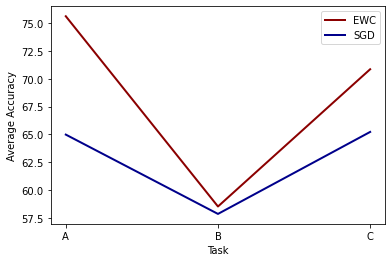


Global Accuracy with EWC: 75.0966673096021
Backward Transfer with EWC: -30.550000071525574
Remembering with EWC: 69.44999992847443

Global Accuracy with SGD: 69.52666739622752
Backward Transfer with SGD: -41.106669108072914
Remembering with SGD: 58.893330891927086


In [ ]:
# Plot the results here (anything is okay)

# Collect accuracies for task accoss the EWC models
acc_taskA =[Acc_A_with_taskA[-1], Acc_A_with_taskB[-1], Acc_A_with_taskC[-1]]
acc_taskB =[Acc_B_with_taskA[-1], Acc_B_with_taskB[-1], Acc_B_with_taskC[-1]]
acc_taskC =[Acc_C_with_taskA[-1], Acc_C_with_taskB[-1], Acc_C_with_taskC[-1]]

# Collect accuracies for task accoss the SGD models
acc_taskA_SGD =[Acc_A_with_taskA[-1], Acc_A_with_taskB_SGD[-1], Acc_A_with_taskC_SGD[-1]]
acc_taskB_SGD =[Acc_B_with_taskA[-1], Acc_B_with_taskB_SGD[-1], Acc_B_with_taskC_SGD[-1]]
acc_taskC_SGD =[Acc_C_with_taskA[-1], Acc_C_with_taskB_SGD[-1], Acc_C_with_taskC_SGD[-1]]

# Calculate average accuracy per task with EWC models
avg_acc_taskA = sum(acc_taskA) / 3
avg_acc_taskB = sum(acc_taskB) / 3
avg_acc_taskC = sum(acc_taskC) / 3

# Calculate average accuracy per task with SGD models
avg_acc_taskA_SGD = sum(acc_taskA_SGD) / 3
avg_acc_taskB_SGD = sum(acc_taskB_SGD) / 3
avg_acc_taskC_SGD = sum(acc_taskC_SGD) / 3

# Collect values for Global Accuracy and Back Transfer for EWC
acc_for_global = [Acc_A_with_taskA[-1], Acc_A_with_taskB[-1], Acc_B_with_taskB[-1], Acc_A_with_taskC[-1], Acc_B_with_taskC[-1], Acc_C_with_taskC[-1]]
acc_for_backtransf = [Acc_A_with_taskB[-1] - Acc_B_with_taskB[-1], Acc_A_with_taskC[-1] - Acc_C_with_taskC[-1], Acc_B_with_taskC[-1] - Acc_C_with_taskC[-1]]

# Collect values for Global Accuracy and Back Transfer for SGD
acc_for_global_SGD = [Acc_A_with_taskA[-1], Acc_A_with_taskB_SGD[-1], Acc_B_with_taskB_SGD[-1], Acc_A_with_taskC_SGD[-1], Acc_B_with_taskC_SGD[-1], Acc_C_with_taskC_SGD[-1]]
acc_for_backtransf_SGD = [Acc_A_with_taskB_SGD[-1] - Acc_B_with_taskB_SGD[-1], Acc_A_with_taskC_SGD[-1] - Acc_C_with_taskC_SGD[-1], Acc_B_with_taskC_SGD[-1] - Acc_C_with_taskC_SGD[-1]]

# Collect values for plotting 
acc_plot_EWC = [avg_acc_taskA, avg_acc_taskB, avg_acc_taskC]
acc_plot_SGD = [avg_acc_taskA_SGD, avg_acc_taskB_SGD, avg_acc_taskC_SGD]

# Calculate global accuracy
global_accuracy = BackwardTransfer(list_accuracies = acc_for_global).calculate_global_accuracy()
global_accuracy_SGD = BackwardTransfer(list_accuracies = acc_for_global_SGD).calculate_global_accuracy()

# Calculate backward transfer
backward_transfer = BackwardTransfer(list_accuracies = acc_for_backtransf).calculate_BackwardTransfer()
REM = 100 - abs(min(backward_transfer, 0))
backward_transfer_SGD = BackwardTransfer(list_accuracies = acc_for_backtransf_SGD).calculate_BackwardTransfer()
REM_SGD = 100 - abs(min(backward_transfer_SGD, 0))

plt.plot(['A','B','C'], acc_plot_EWC, label='EWC', color="darkred", linewidth=2)
plt.plot(['A','B','C'], acc_plot_SGD, label='SGD', color="darkblue", linewidth=2)
plt.legend()
plt.xlabel("Task")
plt.ylabel("Average Accuracy")
plt.show()

print("\nGlobal Accuracy with EWC:", global_accuracy)
print("Backward Transfer with EWC:",backward_transfer)
print("Remembering with EWC:",REM)
print("\nGlobal Accuracy with SGD:", global_accuracy_SGD)
print("Backward Transfer with SGD:",backward_transfer_SGD)
print("Remembering with SGD:",REM_SGD)

As shown in the previous chart, the EWC has, in general, a better behaviour than the SGD, at least compared in terms of how well it dealt with the **catastrophic forgetting**. In summary:

- For tasks A, B and C, there is a better accuracy when using EWC rather than SGD. This improvement is more evident for tasks A (Buildings and Forest) and C (Street and Sea).
- Comparing the global accuracy, the EWC performs much better than SGD, where the former has 6 more points of accuracy than the latter.
- With respet to how much training on a new task has improved the previous tasks (backward transfer), the EWC approach is smaller than the SGD, proving that the first one is better.
- In terms of Remembering, the EWC improves around 18% of the behaviour of the SGD.

**References**

To deal with the challenges in the assignment, I looked to the following sources to understand specific topics to solve each exercise.

1. Díaz-Rodríguez, N., et al., 2018. Don’t forget, there is more than forgetting: new metrics for Continual Learning.
arXiv preprint arXiv:1810.13166.
2. Kirkpatrick, J., et al., (2017). Overcoming catastrophic forgetting in neural networks. Proceedings of the National
Academy of Sciences, 114(13), pp. 3521-3526.
3. https://github.com/yashkant/Elastic-Weight-Consolidation/blob/master/main.ipynb
4. https://github.com/stijani/elastic-weight-consolidation-tf2/blob/7623363649037680ef1ef95450813fab6426baf5/demo.ipynb
5. https://seanmoriarity.com/2020/10/18/continual-learning-with-ewc/
6. https://www.kaggle.com/krishnayogi/scene-classification-using-transfer-learning/notebook



### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

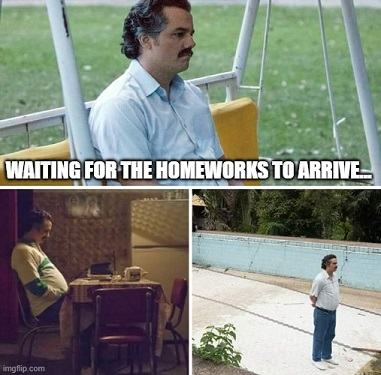